/opt/anaconda3/envs/hoho_RL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/hoho_RL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### two-stage

目标检测分两步： 获取候选区域，然后进行分类

算法：R-CNN系列

### one-stage

一步到位。

算法：SSD、 YOLO

### 常见方法

* 滑动窗口法

暴力法

* R-CNN

通过候选区域获取感兴趣区域(ROI)：首先将每个像素作为一组。然后，计算每一组的纹理，并将两个最接近的组结合起来。继续合并区域，直到所有区域都结合在一起
![./hoho_image1.png](./hoho_image1.png)

之后使用SVM对区域进行分类，使用线性回归损失来校正边界框。

流程图如下：
![./hoho_image2.png](./hoho_image2.png)


* Fast R-CNN

使用CNN网络先提取整个图像的特征，而不是对每个图像块提取多次。然后，我们可以将创建候选区域的方法直接应用到提取到的特征图(feature map)上。


![./hoho_image3.png](./hoho_image3.png)

其中，使用ROI pooling将不同大小的候选区域输出固定大小的特征图：

![./hoho_image6.png](./hoho_image6.png)

总体流程如下：

![./hoho_image4.png](./hoho_image4.png)


* Faster R-CNN

Fast R-CNN 依赖于外部候选区域方法，如选择性搜索（跟R-CNN一样）。Faster R-CNN 采用与 Fast R-CNN 相同的设计，只是它用区域生成网络（Region Proposal Network，RPN）代替了候选区域方法，让网络自己学习自己的候选区域应该是什么。

![./hoho_image5.png](./hoho_image5.png)

### YOLO

就是一连串的卷积神经网络

![./hoho_image7.png](./hoho_image7.png)

神经网络会把448的图最后给卷积成7x7。正好就是7x7的格子。每个格子算出来就是一个点。当然有30个通道。所以每个格子其实映射出了30维的一个向量。

![./hoho_image8.png](./hoho_image8.png)

这30维向量，每个维度作用如下：

![./hoho_image9.png](./hoho_image9.png)


最后从这两个框里选出一个来。最多有7x7x2个框。丢掉置信度小的，合并同一个类别，就得到了识别结果。

### SSD

其实也是一连串卷积神经网络的堆叠，于YOLO差不多

![./hoho_image10.png](./hoho_image10.png)

SSD的框框是预设好的，各种大小的feature map上都有(多个尺度的feature map)。没有YOLO往出来算框框哪一步。由于各个尺寸上都预设了框框。所以最终框出来结果不错。

In [20]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/opt/anaconda3/envs/hoho_RL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/hoho_RL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
image = Image.open('./WechatIMG263.jpeg')
transform_d = transforms.Compose([transforms.ToTensor()])
image_t = transform_d(image)
pred = model([image_t])
print(pred)

[{'boxes': tensor([[ 354.2832,  109.4217, 1185.1381, 1453.2103],
        [   0.0000,  891.8321, 1276.0000, 1702.0000],
        [1018.0714,  404.7932, 1271.2360,  972.1236],
        [ 980.1202,  990.1669, 1276.0000, 1674.4050],
        [ 915.1926, 1002.1591, 1262.5740, 1256.2067],
        [1021.7481, 1331.2942, 1271.0122, 1687.8718],
        [  77.8835,  403.2607,  219.1932,  681.4318],
        [   0.0000, 1030.6963, 1276.0000, 1690.1735],
        [  10.0041,  415.4922,   84.7174,  689.9321],
        [  44.7128,  304.4724, 1276.0000, 1589.5624]],
       grad_fn=<StackBackward0>), 'labels': tensor([17,  3, 64,  3,  3,  3,  1,  4, 44,  3]), 'scores': tensor([0.9971, 0.7613, 0.6397, 0.3882, 0.1724, 0.1419, 0.0975, 0.0748, 0.0729,
        0.0628], grad_fn=<IndexBackward0>)}]


In [24]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__BACKGROUND__', 'person', 'bicycle', 'car', 'motorcycle',
    'airplane', 'bus', 'train', 'trunk', 'boat', 'traffic light',
    'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A',
    'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [27]:
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[ii] for ii in list(pred[0]['labels'].numpy())]
pred_score = list(pred[0]['scores'].detach().numpy())

In [28]:
pred_boxes = [[ii[0], ii[1], ii[2], ii[3]] for ii in list(pred[0]['boxes'].detach().numpy())]
pred_index = [pred_score.index(x) for x in pred_score if x > 0.5]

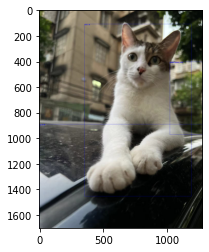

In [37]:
fontsize = np.int16(image.size[1] / 20)
font1 = ImageFont.load_default()

draw = ImageDraw.Draw(image)
for index in pred_index:
    box = pred_boxes[index]
#     cv2.rectangle(img=image, pt1=[int(box[0]), int(box[1])], pt2=[int(box[2]), int(box[3])], color=(0, 0, 225), thickness=3)
    draw.rectangle(box, outline='blue')
    texts = pred_class[index] + ';' + str(np.round(pred_score[index], 2))
    draw.text((box[0], box[1]), texts, fill='blue', font=font1)
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(image, texts, (int(box[0]), int(box[1])), font, 1, (200, 255, 155), cv2.LINE_AA)
    
# cv2.imshow(image)
plt.imshow(image)

In [29]:
pred_index

[0, 1, 2]